<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Global map of sediment thickness
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
</p>
<p style="color:rgb(90,90,90);">
Copyright (c) 2018 Guillaume Rongier
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook shows how to import, plot, and save the global map of sediment thickness made by Laske and Masters (1997) at a 1&times;1 &deg; resolution using Python. More information about the map is available here:

[igppweb.ucsd.edu/~gabi/sediment.html](https://igppweb.ucsd.edu/~gabi/sediment.html)

*G. Laske and G. Masters, A Global Digital Map of Sediment Thickness, EOS Trans. AGU, 78, F483, 1997*

# Package imports

In [1]:
%matplotlib notebook

# To import the data
import numpy as np

# To map the data with folium
import folium
from rasterio import warp, transform

# To map the data with matplotlib and cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

# Function definitions

In [2]:
def read_gmt_file(gmt_file_path):
    '''
    Read a .gmt file data
    
    @param gmt_file_path: The path to the file
    
    @return A NumPy array containing the data
    '''
    gmt_nodes = []
    with open(gmt_file_path) as gmt_file:
        for line in gmt_file:
            line_list = line.rstrip('\n').split()
            gmt_node = [float(i) for i in line_list]
            gmt_nodes.append(gmt_node)
            
    return np.array(gmt_nodes)

def colorize_array(array, cmap = 'viridis'):
    '''
    Turn an array's values into color values
    
    @param array: A NumPy array
    
    @return The color values
    '''
    normalized_array = (array - np.min(array))/(np.max(array) - np.min(array))
    cm = plt.cm.get_cmap(cmap)
    
    return cm(normalized_array)

# Download the data

We can download the sediment thickness from the *Download section* of [igppweb.ucsd.edu/~gabi/sediment.html](igppweb.ucsd.edu/~gabi/sediment.html):

[igpppublic.ucsd.edu/~gabi/ftp/sediment.tar.gz](http://igpppublic.ucsd.edu/~gabi/ftp/sediment.tar.gz)

We just have to uncompress the archive where this notebook is.

# Import the data

We need to read the sediment thickness from the .gmt file.

In [3]:
gmt_file_path = './sediment/sedmap.gmt'

gmt_nodes = read_gmt_file(gmt_file_path)

Then, we reshape the data to get the map of sediment thickness.

In [4]:
map_width = 360
map_height = 180

sediment_thickness = gmt_nodes.reshape((map_height, map_width, gmt_nodes.shape[-1]))
sediment_thickness = np.moveaxis(sediment_thickness, -1, 0)

# Plot the map with folium

By default, folium uses a [Web Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator), which is undefined at the poles. Thus, coverage stops slightly above 85 &deg;N, and slightly below 85 &deg;S, and we need to truncate the map.

In [5]:
trunc_sediment_thickness = sediment_thickness[:, (-85 < sediment_thickness[1]) & (sediment_thickness[1] < 85)]
trunc_sediment_thickness = trunc_sediment_thickness.reshape((3, trunc_sediment_thickness.size//(360*3), 360))

We define the extent of the truncated map, which is needed for projecting it and plotting it.

In [6]:
x_min = np.min(trunc_sediment_thickness[0])
x_max = np.max(trunc_sediment_thickness[0])
y_min = np.min(trunc_sediment_thickness[1])
y_max = np.max(trunc_sediment_thickness[1])

x_spacing = (x_max - x_min)/(trunc_sediment_thickness.shape[2] - 1)
y_spacing = (y_max - y_min)/(trunc_sediment_thickness.shape[1] - 1)

x_min -= x_spacing/2.
x_max += x_spacing/2.
y_min -= y_spacing/2.
y_max += y_spacing/2.

Now we can project the map from latitude/longitude (EPSG code 4326) to the Web Mercator projection (EPSG code 3857).

In [7]:
src_crs = {'init': 'EPSG:4326'}
dst_crs = {'init': 'EPSG:3857'}

src_transform = transform.from_bounds(x_min, y_min, x_max, y_max,
                                      trunc_sediment_thickness.shape[2],
                                      trunc_sediment_thickness.shape[1])
dst_transform, dst_width, dst_height = warp.calculate_default_transform(src_crs,
                                                                        dst_crs,
                                                                        trunc_sediment_thickness.shape[2],
                                                                        trunc_sediment_thickness.shape[1],
                                                                        x_min, y_min, x_max, y_max)
mercator_sediment_thickness = np.empty((dst_height, dst_width))

warp.reproject(trunc_sediment_thickness[2],
               mercator_sediment_thickness,
               src_transform = src_transform,
               src_crs = src_crs,
               dst_transform = dst_transform,
               dst_crs = dst_crs)

Folium doesn't seem to manage well the conversion from the array's values to RGB, so we do that ourselves.

In [8]:
colored_sediment_thickness = colorize_array(mercator_sediment_thickness, cmap = 'plasma')

Finally, we can plot the map.

In [9]:
# Create the folium map
folium_map = folium.Map(location = [0., 0.],
                        tiles = 'Stamen Terrain',
                        zoom_start = 2,
                        no_wrap = True,
                        max_bounds = True,
                        control_scale = True)

# Overlay the image
image = folium.raster_layers.ImageOverlay(name = 'Sediment thickness',
                                          image = colored_sediment_thickness,
                                          bounds = [[y_min, x_min], [y_max, x_max]],
                                          opacity = 0.6,
                                          interactive = True,
                                          cross_origin = False,
                                          zindex = 1)
image.add_to(folium_map)
folium.LayerControl().add_to(folium_map)

# Display the map
folium_map

# Plot the map with matplotlib and cartopy

Matplotlib and cartopy let us use more diverse projections, although in a less interactive format. Here, we use the [Mollweide projection](https://en.wikipedia.org/wiki/Mollweide_projection).

<IPython.core.display.Javascript object>


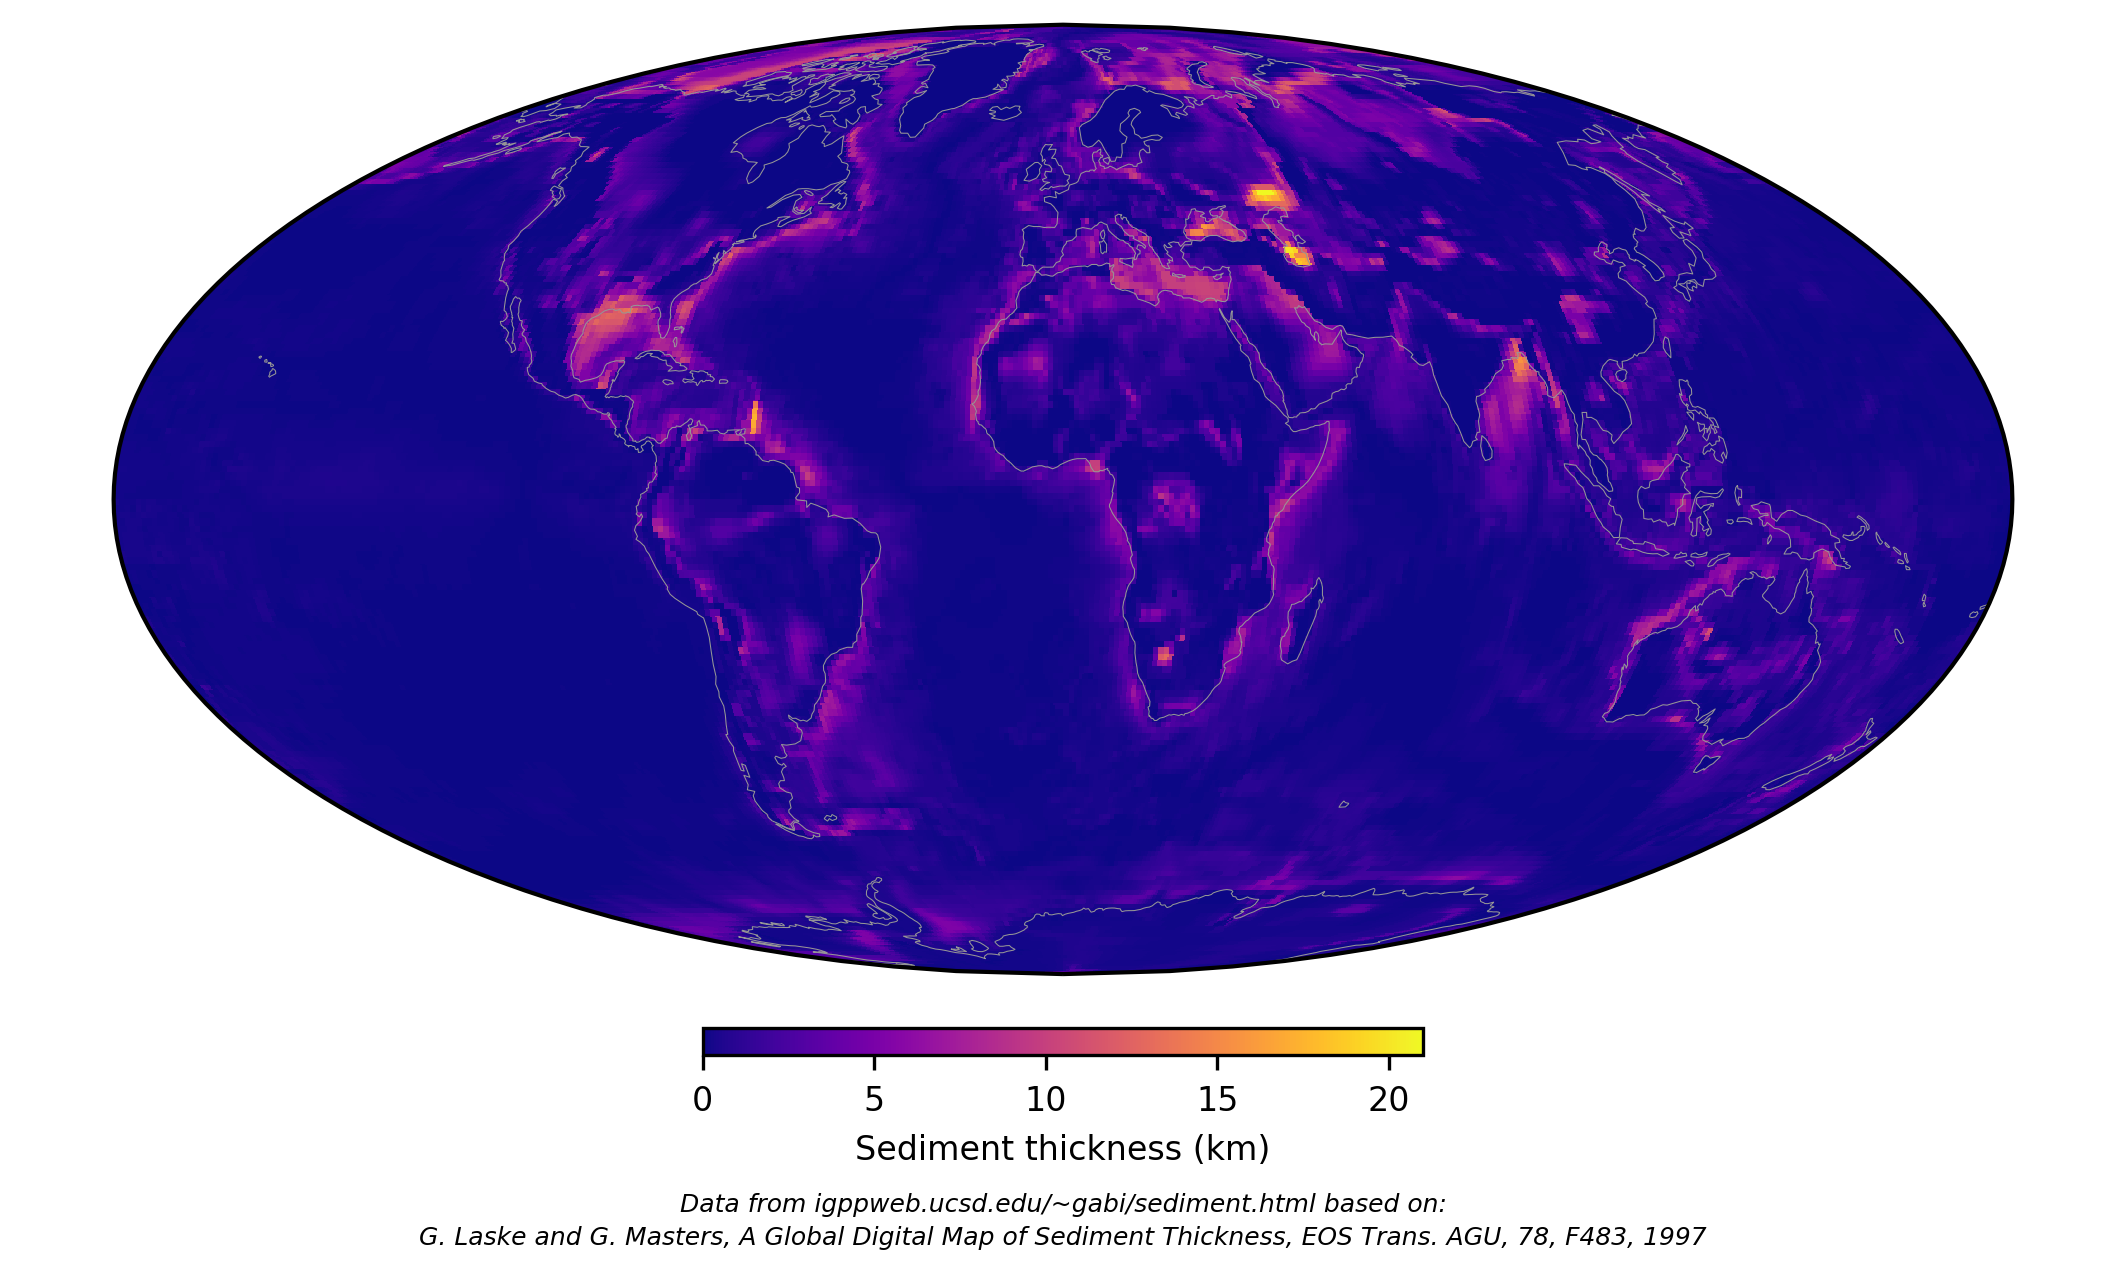

In [10]:
# Define the figure size and resolution
fig_width = 18 # cm
fig_height = 10.75 # cm
fig_dpi = 150

figure = plt.figure(figsize = (fig_width/2.54, fig_height/2.54), dpi = fig_dpi)
gs = gridspec.GridSpec(3, 3,
                       height_ratios = [0.875, 0.025, 0.1],
                       width_ratios = [0.3, 0.4, 0.3],
                       hspace = 0.15)
# Define the axes and map projection
ax = plt.subplot(gs[0, 0:3], projection = ccrs.Mollweide())
cax = plt.subplot(gs[1, 1])
rax = plt.subplot(gs[2, 0:3])
# Adjust whitespace around the figure
figure.subplots_adjust(left = 0.02, right = 0.98, bottom = 0.04, top = 0.98)

# Plot the map as an image
image = ax.imshow(np.ma.masked_invalid(sediment_thickness[2]),
                  transform = ccrs.PlateCarree(),
                  origin = 'upper',
                  cmap = 'plasma',
                  interpolation = 'None',
                  rasterized = True)
# Add the coastlines
ax.coastlines(resolution = '110m', color = '#969696', linewidth = 0.25)
# Add a colorbar at the bottom
image_colorbar = plt.colorbar(image,
                              cax = cax,
                              orientation = 'horizontal',
                              ticks = np.arange(0., np.max(sediment_thickness[2]), 5.))
image_colorbar.ax.tick_params(labelsize = 8)
image_colorbar.set_label('Sediment thickness (km)', size = 8)

# Add the reference
rax.axis('off')
rax.text(0.5,
         -0.25,
         'Data from igppweb.ucsd.edu/~gabi/sediment.html based on:\nG. Laske and G. Masters, A Global Digital Map of Sediment Thickness, EOS Trans. AGU, 78, F483, 1997',
         ha = 'center',
         size = 6,
         style = 'italic', linespacing = 1.5)

# Add the gridlines for latitude and longitude
# gl = ax.gridlines(xlocs = [180., 120., 0., -120., -180],
#                   ylocs = [90., 60., 0., -60., -90.],
#                   linestyle = 'dashed',
#                   linewidth = 0.25,
#                   color = '#525252')
# ax_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
# ax.annotate('60°', xy = (-180, 60), xytext = (-8, 0), xycoords = ax_transform, textcoords = "offset points", ha = 'right', va = 'center', color = '#525252', size = 5)
# ax.annotate('0°', xy = (-180, 0), xytext = (-2, 0), xycoords = ax_transform, textcoords = "offset points", ha = 'right', va = 'center', color = '#525252', size = 5)
# ax.annotate('-60°', xy = (-180, -60), xytext = (-8, 0), xycoords = ax_transform, textcoords = "offset points", ha = 'right', va = 'center', color = '#525252', size = 5)
# ax.annotate('120°', xy = (120, 0), xytext = (2, 1), xycoords = ax_transform, textcoords = "offset points", ha = 'left', va = 'bottom', color = '#525252', size = 5)
# ax.annotate('0°', xy = (0, 0), xytext = (2, 1), xycoords = ax_transform, textcoords = "offset points", ha = 'left', va = 'bottom', color = '#525252', size = 5)
# ax.annotate('-120°', xy = (-120, 0), xytext = (2, 1), xycoords = ax_transform, textcoords = "offset points", ha = 'left', va = 'bottom', color = '#525252', size = 5)

# Display the figure
plt.show()

We can also save the figure as a .pdf file.

In [11]:
fig_path = '.'
fig_name = 'Global_Sediment_Thickness_Map'
fig_format = 'pdf'

figure.savefig(fig_path + '/' + fig_name + "." + fig_format, dpi = 'figure', format = fig_format)